# Mini Project III

|**Data Tables**| Description | Subset of |
|---|---|---|
|twm_customer|information about customers|
|twm_accounts|information about accounts
|twm_checking_accounts|information about checking accounts|twm_accounts
|twm_credit_accounts|information about checking accounts|twm_accounts|
|twm_savings_accounts|information about checking accounts|twm_accounts
|twm_transactions|information about financial transactions
|twm_savings_tran|information about savings transactions|twm_transactions
|twm_checking_tran|information about savings transactions|twm_transactions
|twm_credit_tran|information about credit checking|twm_transactions

Data Preparation steps:  
    Check nan -> remove or replace  
    Check duplicate -> remove  
    Check for outliers -> seaborn pairplot on numeric data  
    Identify categorical, numerical, ordinal  
    Transform numeric data to make more normal -> binning, 
```python
df.apply(np.log)  # not neccessary in an unsupervised scenario
```
    Scale  
    OneHotEncode non-ordinal categorical features ->
```python
pd.get_dummies()
```
    LabelEncode ordinal categorical features ->
```python
df.replace({'feature' : {'1st' : 1, '2nd' : 2, ...}})
```
    
    

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import sqlite3
from sqlite3 import Error

#### Create Database

In [ ]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [ ]:
connection = create_connection('mini-project-III-data/bank.sqlite')

Connection to SQLite DB successful


In [ ]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

In [ ]:
# Read the twm_customer.csv to a dataframe
customers = pd.read_csv('mini-project-III-data/twm_customer.csv',
                        delimiter=';')

##### Identify which feature or combination are unique indices

In [ ]:
duplicates = customers.shape[0] - len(set(customers['cust_id']))
duplicates

0

In [ ]:
accounts = pd.read_csv('mini-project-III-data/twm_accounts.csv',
                        delimiter=';')

In [ ]:
duplicates = accounts.shape[0] - len(set(accounts['acct_nbr']))
duplicates

0

In [ ]:
check_acct = pd.read_csv('mini-project-III-data/twm_checking_acct.csv',
                        delimiter=';')

In [ ]:
duplicates = check_acct.shape[0] - len(set(check_acct['acct_nbr']))
duplicates

0

In [ ]:
save_acct = pd.read_csv('mini-project-III-data/twm_savings_acct.csv',
                        delimiter=';')

In [ ]:
duplicates = save_acct.shape[0] - len(set(save_acct['acct_nbr']))
duplicates

0

In [ ]:
credit_acct = pd.read_csv('mini-project-III-data/twm_credit_acct.csv',
                        delimiter=';')

In [ ]:
duplicates = credit_acct.shape[0] - len(set(credit_acct['acct_nbr']))
duplicates

0

In [ ]:
transactions = pd.read_csv('mini-project-III-data/twm_transactions.csv',
                        delimiter=';')

In [ ]:
duplicates = transactions.shape[0] - len(set(list(zip(transactions['tran_id'], transactions['acct_nbr']))))
duplicates

0

In [ ]:
check_trans = pd.read_csv('mini-project-III-data/twm_checking_tran.csv',
                        delimiter=';')

In [ ]:
duplicates = check_trans.shape[0] - len(set(list(zip(check_trans['tran_id'], check_trans['cust_id']))))
duplicates

0

In [ ]:
save_trans = pd.read_csv('mini-project-III-data/twm_savings_tran.csv',
                        delimiter=';')

In [ ]:
duplicates = save_trans.shape[0] - len(set(list(zip(save_trans['tran_id'], save_trans['cust_id']))))
duplicates

0

In [ ]:
credit_trans = pd.read_csv('mini-project-III-data/twm_credit_tran.csv',
                        delimiter=';')

In [ ]:
duplicates = credit_trans.shape[0] - len(set(list(zip(credit_trans['tran_id'], credit_trans['cust_id']))))
duplicates

0

##### CREATE AND REPLACE TABLES
Pandas `to_sql()` does not support assigning primary keys. SQLite does not support assigning primary keys using the ALTER TABLE statement. In SQLite primary keys must be set in the CREATE TABLE statement.
For this project, primary keys are not necessary.

## 1. create two separate customer segmentations (using clustering) to split them into 3-5 clusters:

### **Customer Segmentation 1**: based on demographics (only on the information from twm_customer)

In [3]:
# Read the twm_customer.csv to a dataframe
customers = pd.read_csv('mini-project-III-data/twm_customer.csv',
                        delimiter=';')
# Check the size of the customers dataframe
customers.shape

(747, 15)

In [4]:
# print the head of the customers dataframe
customers.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [5]:
# check for na values
customers.isna().sum()

cust_id            0
income             0
age                0
years_with_bank    0
nbr_children       0
gender             0
marital_status     0
name_prefix        0
first_name         0
last_name          0
street_nbr         0
street_name        0
postal_code        0
city_name          0
state_code         0
dtype: int64

In [6]:
# check for duplicate customer ids
idsUnique = len(set(customers['cust_id']))
idsTotal = customers.shape[0]
idsdupe = idsTotal - idsUnique
idsdupe

0

#### Explore the Data

In [8]:
# Check contents of table features
for col in customers.columns[3:8]:
    print(col, set(customers[col]))

years_with_bank {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
nbr_children {0, 1, 2, 3, 4, 5}
gender {'F ', 'M '}
marital_status {1, 2, 3, 4}
name_prefix {'Mr.     ', 'Dr.     ', 'Mrs.    ', '        ', 'Ms.     ', 'Miss    '}


`marital_status` has four categories but no description of what each means.

| Prefix | |
| --- | --- |
| Miss | an unmarried woman |
| Mrs. | a married woman |
| Ms. | any woman |
| Mr. | any man |  
([source](https://www.brides.com/difference-between-miss-ms-mrs-4802684))

In [9]:
# Explore marital status codes
customers[['marital_status', 'name_prefix']]\
    [customers['name_prefix'] == 'Miss    ']\
        .groupby(by=['marital_status', 'name_prefix']).count()

,
marital_status,name_prefix
1,Miss


In [16]:
# Dictionary of marital status
marital_dict = {1: 'Unmarried',
                2: 'Married_1',
                3: 'Married_2',
                4: 'Married_3'}

In [17]:
# Change the data type of marital_status from 'int' to 'category'
customers=customers.astype({'marital_status': 'category'})

In [18]:
# Explore name_prefix
(customers['name_prefix'].value_counts() / customers.shape[0] * 100)\
    .to_frame(name='% of prefixes').round(1)

,% of prefixes
,67.6
Ms.,12.3
Mr.,11.0
Mrs.,4.1
Dr.,2.9
Miss,2.0


Only 3% are labeled as doctors, which probably won't reveal useful insights. The gender and marital status columns take care of the differences between men and women, married and unmarried. `name_prefix` can be dropped.

`postal_code`, `city_name`, and `state_code` might have useful information. Check if insights come from encodeing `state_code` before trying to encode `city_name` and `postal_code`.

In [20]:
# Check for any unreasonable ages
customers['age'].value_counts().sort_index()

13    15
14    15
15    32
16    19
17    21
      ..
85     1
86     1
87     1
88     3
89     2
Name: age, Length: 77, dtype: int64

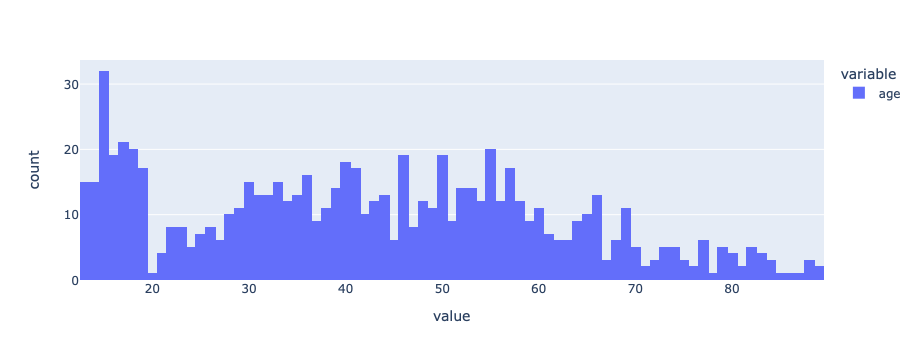

In [23]:
px.histogram(customers['age'], nbins=77)

> Age is a skewed distribution. Consider binning in groups of 20.

In [19]:
# Drop unuseful columns
customers.drop(columns=['cust_id',
                        'name_prefix', 'first_name', 'last_name',
                        'street_nbr', 'street_name', 
                        'postal_code', 'city_name',],
               inplace=True)

#### Scale numeric data

In [85]:
customers_numeric = customers.select_dtypes('int64').copy()

###### Test log transform on income
When it comes to income. There are two groups of people. Those with income, and those without income. For those with an income, they are described by a skew distribution that a log transformation can be applied to.

In [63]:
income_test = customers_numeric['income'].copy()
# income_test.replace(0, 0.49, inplace=True)


In [59]:
income_test = income_test.apply(lambda x: np.log(x + 2))

In [60]:
income_test.sort_values()

594     0.693147
234     0.693147
235     0.693147
83      0.693147
397     0.693147
         ...    
419    11.617340
422    11.758613
246    11.769101
639    11.865524
64     11.878672
Name: income, Length: 747, dtype: float64

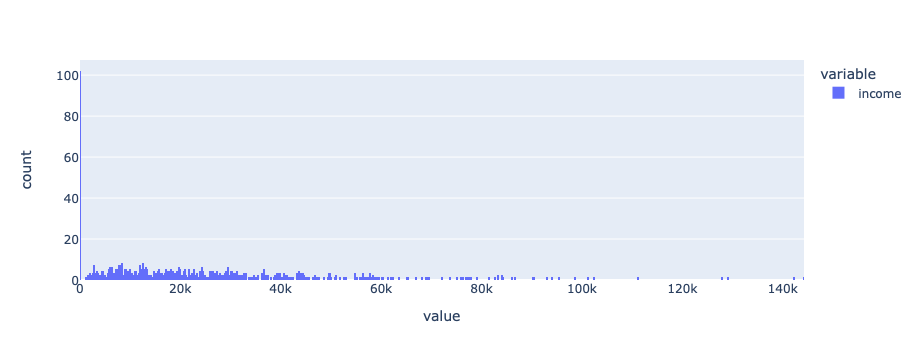

In [65]:
px.histogram(income_test)

Do not apply log transforms to unsupervised data. Log transform forces you to drop 0 values because log(0) == -inf. I want to keep 0 values, because there may be groups around 0 income and 0 children.
Over 100 incomes are 0, nearly 450 customers have no children.

One workaround that might work is to change 0 incomes to 0.0049 (less than 0.5 cents), that way we are not taking log(0) and rounding income to the nearest cent doesn't register any income. Since tax forms round to the nearest dollar, and the income.dtype is int, we may be able to get away with 0.49.
Similarly for no children. We don't take log(0) and we round less than half a child down to zero.
I've got to come back to this.

###### moving on...

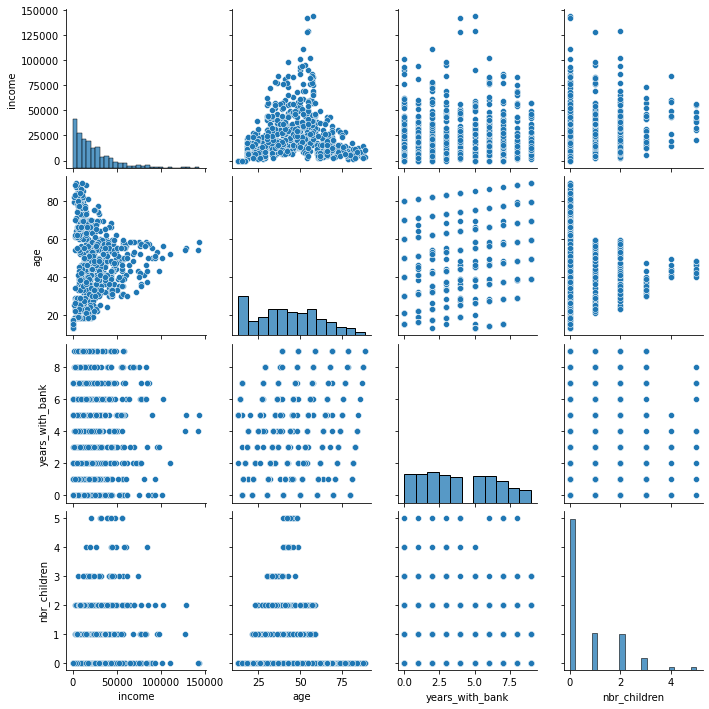

In [25]:
sns.pairplot(customers_numeric)

In [68]:
scaler = StandardScaler()
customers_num_scaled = pd.DataFrame(scaler.fit_transform(customers_numeric.astype(float)),
                                   columns=customers_numeric.columns)

In [69]:
customers_num_scaled.head()

,income,age,years_with_bank,nbr_children
0,0.154185,0.184312,0.408539,0.258591
1,-0.726524,1.493070,-1.087435,-0.648298
2,-0.188366,-0.234490,1.530520,-0.648298
3,1.123798,0.603115,-0.339448,-0.648298
4,0.983479,0.864867,1.904514,1.165479


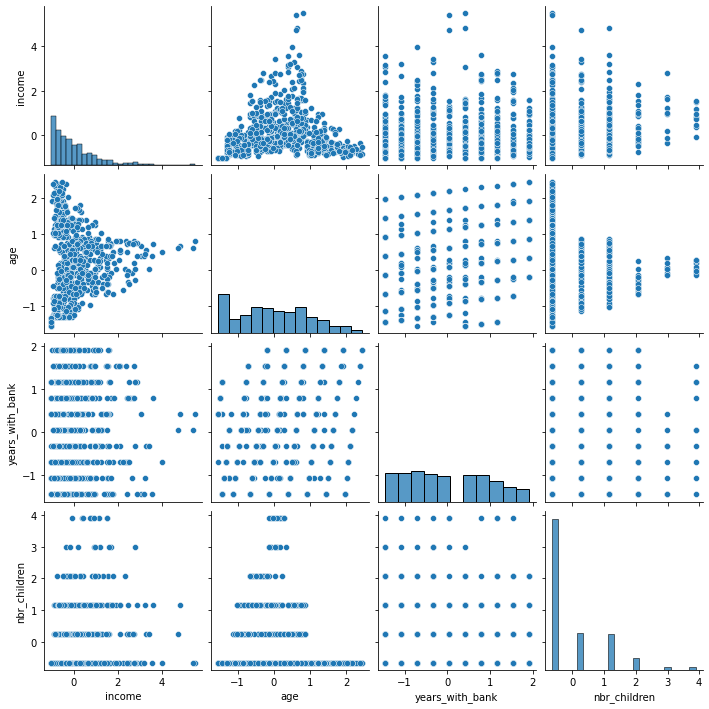

In [270]:
sns.pairplot(customers_num_scaled)

##### SKLearn one hot encoding

In [64]:
# one-hot encode categorical features
encoder = OneHotEncoder(drop='if_binary')
le = LabelEncoder()

In [81]:
data = customers[['gender', 'state_code']]

In [82]:
data_2 = data.apply(le.fit_transform)
data_2.head()

,gender,state_code
0,1,22
1,1,2
2,0,2
3,0,2
4,0,23


In [84]:
data = pd.concat([data_2, customers['marital_status']], axis=1)

In [87]:
encoder

array(['gender', 'state_code', 'marital_status'], dtype=object)

In [85]:
encoder.fit(data)

onehotlabels = encoder.transform(data).toarray()

In [79]:
pd.DataFrame(onehotlabels, columns=encoder.get_feature_names_out())

,gender_1,state_code_0,state_code_1,state_code_2,state_code_3,state_code_4,state_code_5,state_code_6,state_code_7,state_code_8,...,state_code_27,state_code_28,state_code_29,state_code_30,state_code_31,state_code_32,marital_status_1,marital_status_2,marital_status_3,marital_status_4
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
743,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
744,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
745,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### Pandas get dummies

In [70]:
customer_dummy = pd.get_dummies(customers[['gender', 'marital_status',
                                           'state_code']].astype(str), drop_first=True)
customer_dummy.shape

(747, 36)

In [71]:
customer_dummy

,gender_M,marital_status_2,marital_status_3,marital_status_4,state_code_AZ,state_code_CA,state_code_CO,state_code_DC,state_code_FL,state_code_GA,...,state_code_NY,state_code_OH,state_code_OK,state_code_OR,state_code_PA,state_code_TN,state_code_TX,state_code_VA,state_code_WA,state_code_WI
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
743,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
744,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
745,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Drop one hot encoded columns
customers.drop(columns=['gender', 'marital_status', 'state_code'],
              inplace=True)

In [73]:
customers_train = pd.concat([customers_num_scaled, customer_dummy], axis=1)
customers_train.shape

(747, 40)

In [74]:
customers_train.head()

,income,age,years_with_bank,nbr_children,gender_M,marital_status_2,marital_status_3,marital_status_4,state_code_AZ,state_code_CA,...,state_code_NY,state_code_OH,state_code_OK,state_code_OR,state_code_PA,state_code_TN,state_code_TX,state_code_VA,state_code_WA,state_code_WI
0,0.154185,0.184312,0.408539,0.258591,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.726524,1.493070,-1.087435,-0.648298,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.188366,-0.234490,1.530520,-0.648298,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.123798,0.603115,-0.339448,-0.648298,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.983479,0.864867,1.904514,1.165479,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


##### K-means

In [75]:
def plot_distortion(X, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.axvline(x=3, color='k', linestyle='--')
    plt.axvline(x=5, color='k', linestyle='--')
    plt.show()

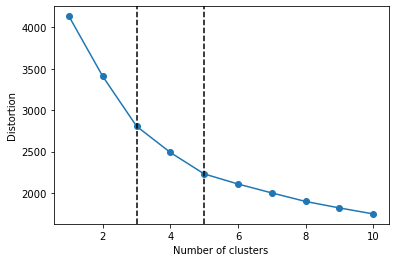

In [78]:
# Use the elbow rule to choose optimal numer of clusters
plot_distortion(customers_train)

>3 clusters looks good enough

In [142]:
# run the model using three clusters
kmodel = KMeans(n_clusters=3,
                n_init=10)

In [143]:
# Identify clusters
y_km = kmodel.fit_predict(customers)

In [144]:
# Check how many data points fall within each cluster
pd.Series(kmodel.labels_).value_counts()

0    459
1    244
2     44
dtype: int64

In [145]:
# Append clusters to customers training data
customers_train['y_km'] = y_km

In [146]:
# The radar chart based on StandardScaler() didn't look so good
# Apply MinMaxScaler() to customers numeric data for radar chart
customers_numeric_mms = scaled_df(customers_numeric, 'mms')
customers_numeric_mms['y_km'] = y_km
customers_numeric_mms.head()

,income,age,years_with_bank,nbr_children,y_km
0,0.181399,0.434211,0.555556,0.2,1
1,0.045818,0.763158,0.111111,0.0,0
2,0.128665,0.328947,0.888889,0.0,0
3,0.330667,0.539474,0.333333,0.0,1
4,0.309066,0.605263,1.000000,0.4,1


In [147]:
# Append clusters to customers numeric data
customers_numeric['y_km'] = y_km

### **Customer Segmentation 2:** based on their banking behavior. We can take following things into consideration as banking behavior:
- do they have savings account? How much do they save?
- do they have credit account? How much do they live in debt?
- are they making lot of small transactions or few huge ones?

Use feature engineering to build a dataframe to train a model.

|cust_id|acct_SV|acct_CK|acct_CC|balance_SV|balance_CK|balance_CC|num_trans_SV|num_trans_CK|num_trans_CC|mean_trans_SV|mean_trans_CK|mean_trans_CC|
|-|-|-|-|-|-|-|-|-|-|-|-|-|
|1|1|0|1|123.45|0|789.10|3|0|8|41.15|0|98.64|
|2|0|0|1|0|0|1112.13|0|0|2|0|0|556.07|

#### Feature Engineering: Build dataframe for model

Primary Keys

|Table|Feature|
|-|-|
|customers|cust_id|
|accounts|acct_nbr|
|check_acct|acct_nbr|
|save_acct|acct_nbr|
|credit_acct|acct_nbr|
|transactions|(acct_nbr, tran_id)|
|check_trans|(cust_id, tran_id)|
|save_trans|(cust_id, tran_id)|
|credit_trans|(cust_id, tran_id)|

Features  
num_accts continuous numeric int  
acct_SV binary int  
acct_CK binary int  
acct_CC binary int  
balance_SV continuous numeric float  
balance_CK continuous numeric float  
balance_CC continuous numeric float  
num_trans_SV continuous numeric int  
num_trans_CK continuous numeric int  
num_trans_CC continuous numeric int  
mean_trans_SV continuous numeric float  
mean_trans_CK continuous numeric float  
mean_trans_CC continuous numeric float  

In [88]:
def feature_has_duplicates(feature):
    dup = feature.shape[0] - len(set(feature))
    if dup == 0:
        return False
    return dup

In [89]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [92]:
# Connect to the database
connection = create_connection('mini-project-III-data/bank.sqlite')

Connection to SQLite DB successful


In [155]:
# Select the entire accounts table
SQL = '''
SELECT
    *
FROM
    accounts;
'''

accounts = pd.read_sql(sql=SQL, con=connection,
                        index_col=['acct_nbr'],
                        parse_dates={'acct_start_date' : '%d.%m.%Y',
                                     'acct_end_date' : '%d.%m.%Y'})
accounts

,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
acct_nbr,,,,,,,
13628063,1362806,SV,Y,1995-12-10,NaT,1430.22,284.58
4561143213627090,1362709,CC,Y,1993-03-15,NaT,266.34,496.15
4561143213628360,1362836,CC,Y,1992-03-18,NaT,55.90,1000.00
13633112,1363311,CK,Y,1995-07-06,NaT,11017.13,968.46
4561143213633610,1363361,CC,Y,1994-06-17,NaT,849.37,462.28
...,...,...,...,...,...,...,...
4561143213625560,1362556,CC,N,1992-01-20,1995-08-19,1433.94,20.00
4561143213626240,1362624,CC,Y,1990-11-29,NaT,632.75,1400.00
4561143213628750,1362875,CC,Y,1989-02-24,NaT,2810.91,3000.00


In [199]:
# Get number of active accounts per customer
a = accounts[accounts['account_active'].str.strip() == 'Y'][['cust_id', 'acct_type']]\
    .groupby(by='cust_id').count()\
    .rename(columns={'acct_type' : 'num_active_accts'})

In [200]:
# Get number of inactive accounts per customer
b = accounts[accounts['account_active'].str.strip() == 'N'][['cust_id', 'acct_type']]\
    .groupby(by='cust_id').count()\
    .rename(columns={'acct_type' : 'num_inactive_accts'})

In [201]:
# Get total number accounts per customer
accts = a.join(b, how='outer').fillna(0).astype(int)
accts['num_accts'] = accts['num_active_accts'] + accts['num_inactive_accts']
accts
# customers has 747 rows. accounts only has 642 cust_ids with active accounts

,num_active_accts,num_inactive_accts,num_accts
cust_id,,,
1362480,2,1,3
1362484,3,0,3
1362485,2,0,2
1362486,2,0,2
1362487,2,1,3
...,...,...,...
1363490,1,0,1
1363491,0,1,1
1363492,3,0,3


In [119]:
# Scale the data
def scaled_df(df, scaler:str):
    if scaler.lower() == 'ss':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    elif scaler.lower() == 'mms':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    
    return pd.DataFrame(scaler.fit_transform(df),
                        index=df.index,
                        columns=df.columns)

In [202]:
accts_ss = scaled_df(accts, 'ss')
accts_mms = scaled_df(accts, 'mms')

In [160]:
accts_ss

,num_active_accts,num_inactive_accts,num_accts
cust_id,,,
1362480,0.113534,1.721582,1.114657
1362484,1.293228,-0.471621,1.114657
1362485,0.113534,-0.471621,-0.150269
1362486,0.113534,-0.471621,-0.150269
1362487,0.113534,1.721582,1.114657
...,...,...,...
1363490,-1.066159,-0.471621,-1.415196
1363491,-2.245853,1.721582,-1.415196
1363492,1.293228,-0.471621,1.114657


In [203]:
# Showing which active accounts each customer has
# I'm not sure if this could be done by one hot encoding acct_type
# From the first round of feature engineering the radar chart indicated that
# the number of inactive accounts a customer has is not a defining feature
# of the clusters.

# Only active accounts
SQL = '''
SELECT
	accounts.cust_id,
	SUM(CASE
			WHEN acct_type LIKE "SV%" AND
                account_active LIKE "Y%" THEN 1
            ELSE 0
        END) AS acct_SV,
	SUM(CASE
            WHEN acct_type LIKE "CK%" AND
                account_active LIKE "Y%" THEN 1
            ELSE 0
        END) AS acct_CK,
	SUM(CASE 
            WHEN acct_type LIKE "CC%" AND
                account_active LIKE "Y%" THEN 1
            ELSE 0
        END) AS acct_CC
FROM
	accounts
GROUP BY accounts.cust_id
;
'''

In [204]:
acct_types = pd.read_sql(sql=SQL, con=connection)
acct_types

,cust_id,acct_SV,acct_CK,acct_CC
0,1362480,1,1,0
1,1362484,1,1,1
2,1362485,0,1,1
3,1362486,1,1,0
4,1362487,0,1,1
...,...,...,...,...
660,1363490,1,0,0
661,1363491,0,0,0
662,1363492,1,1,1
663,1363493,0,1,1


In [205]:
accts = pd.merge(accts_mms, acct_types, on='cust_id')
accts

,cust_id,num_active_accts,num_inactive_accts,num_accts,acct_SV,acct_CK,acct_CC
0,1362480,0.666667,0.5,1.0,1,1,0
1,1362484,1.000000,0.0,1.0,1,1,1
2,1362485,0.666667,0.0,0.5,0,1,1
3,1362486,0.666667,0.0,0.5,1,1,0
4,1362487,0.666667,0.5,1.0,0,1,1
...,...,...,...,...,...,...,...
660,1363490,0.333333,0.0,0.0,1,0,0
661,1363491,0.000000,0.5,0.0,0,0,0
662,1363492,1.000000,0.0,1.0,1,1,1
663,1363493,0.666667,0.5,1.0,0,1,1


In [206]:
SQL = '''
SELECT
	accounts.cust_id,
	SUM(CASE
		WHEN acct_type LIKE "SV%" THEN ending_balance
		ELSE 0
	END) AS end_balance_SV,
	SUM(CASE
		WHEN acct_type LIKE "CK%" THEN ending_balance
		ELSE 0
	END) AS end_balance_CK,
	SUM(CASE
		WHEN acct_type LIKE "CC%" THEN ending_balance
		ELSE 0
	END) AS end_balance_CC
FROM
	accounts
GROUP BY cust_id;
'''

In [207]:
balances = pd.read_sql(sql=SQL, con=connection)
balances

,cust_id,end_balance_SV,end_balance_CK,end_balance_CC
0,1362480,1187.97,86.86,20.00
1,1362484,2122.17,95.32,369.72
2,1362485,0.00,45.49,1100.00
3,1362486,116.24,3312.27,0.00
4,1362487,12.89,1401.21,1548.23
...,...,...,...,...
660,1363490,2301.53,0.00,0.00
661,1363491,17.82,0.00,0.00
662,1363492,1116.10,106.14,6869.00
663,1363493,553.61,2053.90,0.00


In [208]:
balances.iloc[:, 1:] = scaled_df(balances.iloc[:, 1:], 'mms')
balances

,cust_id,end_balance_SV,end_balance_CK,end_balance_CC
0,1362480,0.052957,0.006588,0.002105
1,1362484,0.094601,0.007229,0.038918
2,1362485,0.000000,0.003450,0.115789
3,1362486,0.005182,0.251206,0.000000
4,1362487,0.000575,0.106269,0.162972
...,...,...,...,...
660,1363490,0.102597,0.000000,0.000000
661,1363491,0.000794,0.000000,0.000000
662,1363492,0.049753,0.008050,0.723053
663,1363493,0.024679,0.155770,0.000000


In [209]:
accts = pd.merge(accts, balances, on='cust_id')
accts

,cust_id,num_active_accts,num_inactive_accts,num_accts,acct_SV,acct_CK,acct_CC,end_balance_SV,end_balance_CK,end_balance_CC
0,1362480,0.666667,0.5,1.0,1,1,0,0.052957,0.006588,0.002105
1,1362484,1.000000,0.0,1.0,1,1,1,0.094601,0.007229,0.038918
2,1362485,0.666667,0.0,0.5,0,1,1,0.000000,0.003450,0.115789
3,1362486,0.666667,0.0,0.5,1,1,0,0.005182,0.251206,0.000000
4,1362487,0.666667,0.5,1.0,0,1,1,0.000575,0.106269,0.162972
...,...,...,...,...,...,...,...,...,...,...
660,1363490,0.333333,0.0,0.0,1,0,0,0.102597,0.000000,0.000000
661,1363491,0.000000,0.5,0.0,0,0,0,0.000794,0.000000,0.000000
662,1363492,1.000000,0.0,1.0,1,1,1,0.049753,0.008050,0.723053
663,1363493,0.666667,0.5,1.0,0,1,1,0.024679,0.155770,0.000000


In [210]:
SQL = '''
SELECT
	accounts.cust_id,
	SUM(CASE
			WHEN accounts.acct_type LIKE "SV%" THEN tran.mean_transaction
			ELSE 0
		END) AS mean_save_transaction,
	SUM(CASE
			WHEN accounts.acct_type LIKE "CK%" THEN tran.mean_transaction
			ELSE 0
		END) AS mean_check_transaction,
	SUM(CASE
			WHEN accounts.acct_type LIKE "CC%" THEN tran.mean_transaction
			ELSE 0
		END) AS mean_credit_transaction,
	SUM(CASE
			WHEN accounts.acct_type LIKE "SV%" THEN tran.num_transactions
			ELSE 0
		END) AS num_save_transaction,
	SUM(CASE
			WHEN accounts.acct_type LIKE "CK%" THEN tran.num_transactions
			ELSE 0
		END) AS num_check_transaction,
	SUM(CASE
			WHEN accounts.acct_type LIKE "CC%" THEN tran.num_transactions
			ELSE 0
		END) AS num_credit_transaction
FROM
	accounts
    JOIN (SELECT
            accounts.cust_id,
            transactions.acct_nbr,
            AVG(transactions.tran_amt) AS mean_transaction,
            COUNT(transactions.tran_amt) AS num_transactions
            FROM
                transactions JOIN accounts USING(acct_nbr)
            GROUP BY transactions.acct_nbr) AS tran USING(acct_nbr)
GROUP BY accounts.cust_id;
'''

# This does not check whether the accounts are active anymore
# See if you need an outer join anywhere

In [211]:
transactions = pd.read_sql(sql=SQL, con=connection)
transactions

,cust_id,mean_save_transaction,mean_check_transaction,mean_credit_transaction,num_save_transaction,num_check_transaction,num_credit_transaction
0,1362480,18.550769,-2.474646,60.895625,26,99,32
1,1362484,58.474545,-25.435758,16.797636,33,99,55
2,1362485,0.000000,-1.659495,-10.572639,0,99,72
3,1362486,-6.729600,-37.604800,0.000000,25,25,0
4,1362487,-33.623158,-26.513269,-47.987188,19,52,32
...,...,...,...,...,...,...,...
659,1363490,2.853333,0.000000,0.000000,12,0,0
660,1363491,-10.423889,0.000000,0.000000,18,0,0
661,1363492,6.563200,-12.570404,-61.280690,25,99,29
662,1363493,11.706842,-41.110505,0.000000,19,99,0


In [212]:
transactions.iloc[:, 1:] = scaled_df(transactions.iloc[:, 1:], 'mms')
transactions

,cust_id,mean_save_transaction,mean_check_transaction,mean_credit_transaction,num_save_transaction,num_check_transaction,num_credit_transaction
0,1362480,0.375927,0.717276,0.045422,0.419355,1.000000,0.206452
1,1362484,0.512149,0.621546,0.040569,0.532258,1.000000,0.354839
2,1362485,0.312631,0.720674,0.037557,0.000000,1.000000,0.464516
3,1362486,0.289669,0.570811,0.038720,0.403226,0.252525,0.000000
4,1362487,0.197907,0.617054,0.033440,0.306452,0.525253,0.206452
...,...,...,...,...,...,...,...
659,1363490,0.322366,0.727593,0.038720,0.193548,0.000000,0.000000
660,1363491,0.277064,0.727593,0.038720,0.290323,0.000000,0.000000
661,1363492,0.335024,0.675184,0.031977,0.403226,1.000000,0.187097
662,1363493,0.352575,0.556195,0.038720,0.306452,1.000000,0.000000


In [213]:
accts = pd.merge(accts, transactions, on='cust_id')
accts.set_index('cust_id', inplace=True)
accts.head()

,num_active_accts,num_inactive_accts,num_accts,acct_SV,acct_CK,acct_CC,end_balance_SV,end_balance_CK,end_balance_CC,mean_save_transaction,mean_check_transaction,mean_credit_transaction,num_save_transaction,num_check_transaction,num_credit_transaction
cust_id,,,,,,,,,,,,,,,
1362480,0.666667,0.5,1.0,1,1,0,0.052957,0.006588,0.002105,0.375927,0.717276,0.045422,0.419355,1.000000,0.206452
1362484,1.000000,0.0,1.0,1,1,1,0.094601,0.007229,0.038918,0.512149,0.621546,0.040569,0.532258,1.000000,0.354839
1362485,0.666667,0.0,0.5,0,1,1,0.000000,0.003450,0.115789,0.312631,0.720674,0.037557,0.000000,1.000000,0.464516
1362486,0.666667,0.0,0.5,1,1,0,0.005182,0.251206,0.000000,0.289669,0.570811,0.038720,0.403226,0.252525,0.000000
1362487,0.666667,0.5,1.0,0,1,1,0.000575,0.106269,0.162972,0.197907,0.617054,0.033440,0.306452,0.525253,0.206452


In [ ]:
SQL = '''
SELECT
	customers.cust_id
FROM customers
WHERE customers.cust_id NOT IN
(SELECT accounts.cust_id
FROM accounts);
'''
# There are 82 customers in the customers table that are not in the accounts table.

#### Fit Cluster Model

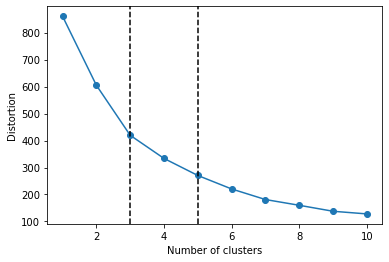

In [214]:
plot_distortion(accts)
# Results: Doesn't look like there is an elbow. Will use 3 clusters.

In [215]:
behaviour_kmodel = KMeans(n_clusters=3, n_init=10)

In [216]:
behaviour_clusters = behaviour_kmodel.fit_predict(accts)

In [217]:
# Add cluster labels to accts table
accts['clusters'] = behaviour_clusters

## 2. visualize the created clusters using [radar charts](https://plotly.com/python/radar-chart/) and compare them agains each other

### Demographic Segmentation

In [184]:
categories = customers_numeric_mms.columns.to_list()

In [185]:
radar_df = customers_numeric_mms.groupby(by='y_km').mean()
radar_df

,income,age,years_with_bank,nbr_children
y_km,,,,
0,0.064484,0.349215,0.419753,0.094989
1,0.255150,0.443755,0.460383,0.226230
2,0.589089,0.481459,0.439394,0.181818


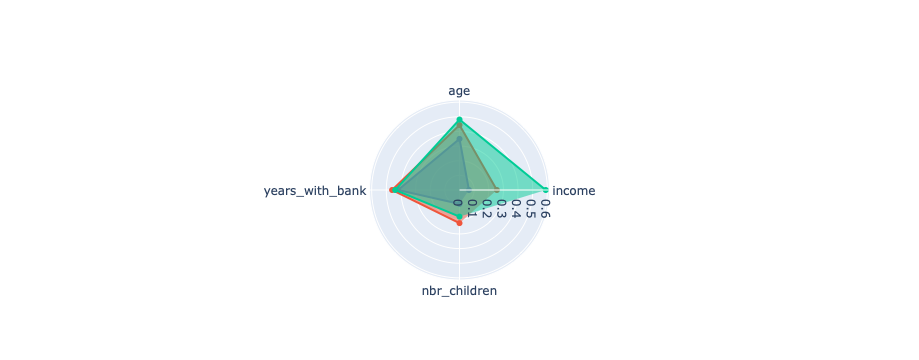

In [186]:
fig = go.Figure()

for cluster in range(radar_df.shape[0]):
    fig.add_trace(go.Scatterpolar(
        r=radar_df.iloc[cluster, :5],
        theta=categories,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True,
                               range=[0, max(customers_numeric_mms)])),
    showlegend=False)

### Banking Behaviour Segmentation

In [218]:
categories = accts.columns.to_list()

In [228]:
behaviour_radar_df = accts.groupby(by='clusters').mean()
behaviour_radar_df

,num_active_accts,num_inactive_accts,num_accts,acct_SV,acct_CK,acct_CC,end_balance_SV,end_balance_CK,end_balance_CC,mean_save_transaction,mean_check_transaction,mean_credit_transaction,num_save_transaction,num_check_transaction,num_credit_transaction
clusters,,,,,,,,,,,,,,,
0,0.50000,0.158898,0.408898,0.000000,0.911017,0.588983,0.006506,0.047194,0.089047,0.324426,0.652798,0.038957,0.053445,0.940293,0.200519
1,0.89715,0.063197,0.908922,1.000000,0.940520,0.750929,0.059655,0.052853,0.093383,0.354460,0.662187,0.044337,0.432906,0.881304,0.219475
2,0.39413,0.103774,0.194969,0.666667,0.000000,0.515723,0.037881,0.003374,0.076957,0.340061,0.720449,0.043089,0.323291,0.048599,0.149361


In [231]:
behaviour_radar_df.sort_values(by=1, axis=1, inplace=True)

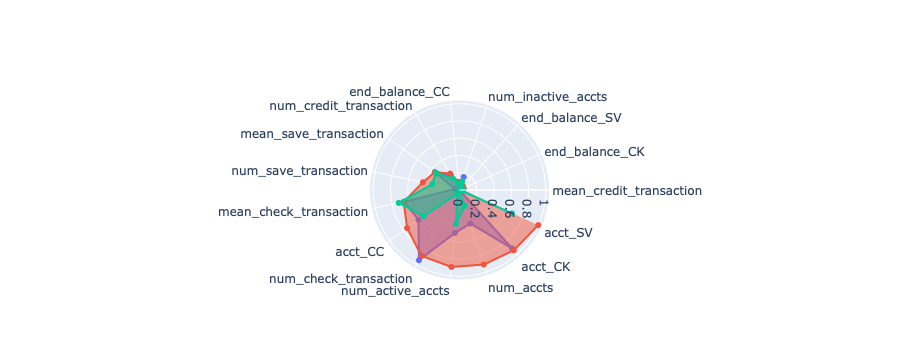

In [233]:
fig = go.Figure()

for cluster in range(behaviour_radar_df.shape[0]):
    fig.add_trace(go.Scatterpolar(
        r=behaviour_radar_df.iloc[cluster, :],
        theta=behaviour_radar_df.columns.to_list(),
        fill='toself',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True,
                               range=[0, max(accts.iloc[:, 1:])])),
    showlegend=False)

## 3. visualize segmentations using scatter plot. We will have to use PCA to be able to plot our observations in 2D.

### Demographic Segmentation

In [190]:
n_components = 2
pca = PCA(n_components=n_components)
components = pca.fit_transform(customers_train.iloc[:, :-1])
labels = {
    str(i): f'PC {i+1} ({var:.1f}%)'
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

label_dict = {0: 'cluster 0',
             1: 'cluster 1',
             2: 'cluster 2'}

In [191]:
total_var = pca.explained_variance_ratio_.sum() * 100
print(f'Total Explained Variance: {total_var:.2f}%')

Total Explained Variance: 47.11%


In [192]:
labels

{'0': 'PC 1 (25.8%)', '1': 'PC 2 (21.4%)'}

In [193]:
def plot_pca(components):
    
    fig = px.scatter(
        data_frame=components,
        x=components[:, 0],
        y=components[:, 1],
        labels={'x': f'PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)', 
               'y': f'PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)'},
        color=customers_train.iloc[:, -1].map(label_dict)
    )
    
    fig.show()

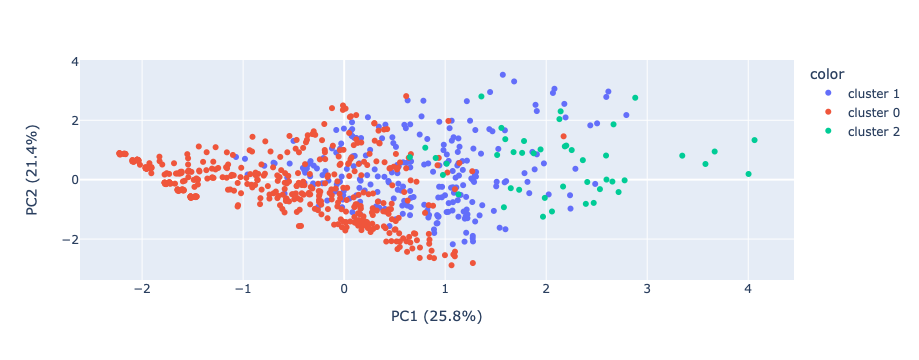

In [194]:
plot_pca(components=components)

### Behaviour Segmentation

In [234]:
n_components = 2
pca = PCA(n_components=n_components)
components = pca.fit_transform(accts.iloc[:, :-1])
labels = {
    str(i): f'PC {i+1} ({var:.1f}%)'
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

label_dict = {0: 'cluster 0',
             1: 'cluster 1',
             2: 'cluster 2'}

In [235]:
total_var = pca.explained_variance_ratio_.sum() * 100
print(f'Total Explained Variance: {total_var:.2f}%')

Total Explained Variance: 65.84%


In [242]:
def plot_pca(components):
    
    fig = px.scatter(
        data_frame=components,
        x=components[:, 0],
        y=components[:, 1],
        labels={'x': f'PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)', 
               'y': f'PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)'},
        color=accts.iloc[:, -1].map(label_dict),
        title= f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.1f}%'
    )
    
    fig.show()

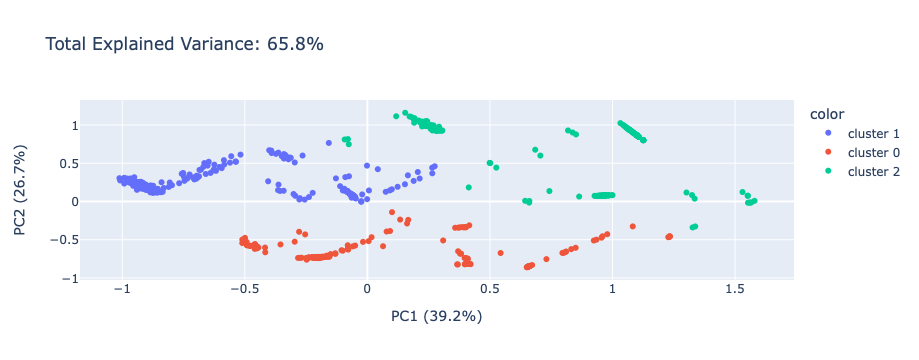

In [243]:
plot_pca(components=components)

## 4. (stretch) visualize in 2D how our clusters are evolving in each iteration of KMeans (for at least 20 iterations).
    - we will need to create own implementation of kmeans so we can see what is happening with the clusters during the iterations.